I did this a bit flippantly before, but I want to fomalize the process by which we estimate the uncertainty on emulator predictions. 

In [2]:
from pearce.emulator import SpicyBuffalo, LemonPepperWet
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [3]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [4]:
#xi gg
training_file = '/scratch/users/swmclau2/xi_zheng07_cosmo_lowmsat/PearceRedMagicXiCosmoFixedNd.hdf5'
#test_file= '/scratch/users/swmclau2/xi_zheng07_cosmo_test_lowmsat2/'
test_file =  '/scratch/users/swmclau2/xi_zheng07_cosmo_test_lowmsat2/PearceRedMagicXiCosmoFixedNd_Test.hdf5'

In [5]:
em_method = 'gp'
split_method = 'random'

In [6]:
a = 1.0
z = 1.0/a - 1.0

In [7]:
fixed_params = {'z':z}#, 'cosmo': 0}#, 'r':24.06822623}

In [8]:
np.random.seed(0)
emu = LemonPepperWet(training_file, method = em_method, fixed_params=fixed_params,
                 custom_mean_function = None, downsample_factor = 0.05)#, hyperparams = {'metric':metric})

1.29305147766 2.62133836608 -0.296509213949
[ 6.94889833  1.01607775  5.08172781  4.74598794  5.89441921  3.19114024
  3.69313406  0.21167359  6.76853007  1.62040107  3.65072859] [  9.32171323   3.51376161   3.29787733   9.50341227   5.29640994
   8.44108538   4.82738836   1.39618562  11.00360705   0.93187517
   3.49757463]


In [9]:
pred_y, data_y = emu.goodness_of_fit(test_file, statistic = None)

In [10]:
train_err = []
for ridx in xrange(emu.n_bins):
    fixed_params = {'r': emu.scale_bin_centers[ridx]}
    fixed_params.update(emu.fixed_params)

    #test_x, test_y, test_ycov, info = emu.get_data(test_file, fixed_params)

    train_x, train_y, train_ycov, info = emu.get_data(training_file, fixed_params, remove_nans = False)

    #test_ycov = test_ycov[:, 0,0]
    train_ycov = train_ycov[:, 0,0]

    #print np.mean(test_y*np.sqrt(test_ycov))
    train_err.append(np.sqrt(np.nanmean(train_ycov)))

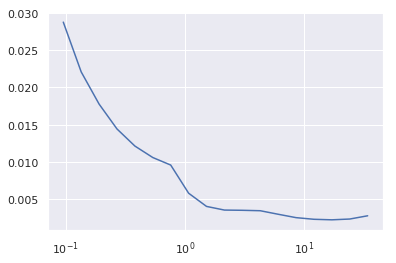

In [11]:
plt.plot(emu.scale_bin_centers, train_err)
plt.xscale('log')

In [12]:
acc = []
log_acc = []
for ridx in xrange(emu.n_bins):
    py, dy = pred_y[ridx], data_y[ridx]
    acc.append(np.mean(np.abs(10**py-10**dy)/(10**dy)) )
    log_acc.append(np.mean(np.abs(py-dy)/dy) )

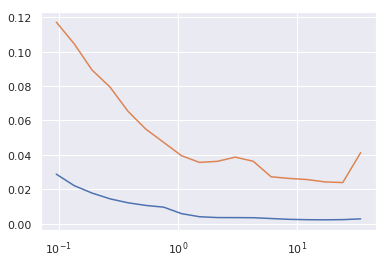

In [13]:
plt.plot(emu.scale_bin_centers, train_err)
plt.plot(emu.scale_bin_centers, acc)
plt.xscale('log')

In [14]:
from pearce.mocks.kittens import TrainingBox

In [15]:
cat = TrainingBox(0, system = 'sherlock')

In [16]:
cat.load(1.0, HOD = 'redMagic')

In [17]:
train_x[:, -4:]

array([[ 13.91381381,   0.12007007,  13.18858859,   0.87287287],
       [ 14.22462462,   0.20940941,  14.55795796,   0.88008008],
       [ 13.84024024,   0.17437437,  13.96786787,   0.86166166],
       ..., 
       [ 13.85375375,   0.12107107,  13.38978979,   0.9017017 ],
       [ 14.57747748,   0.2522022 ,  14.04444444,   1.1995996 ],
       [ 13.63603604,   0.26471471,  13.75165165,   0.91771772]])

In [18]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'ln10As',
 'H0',
 'Neff',
 'logM0',
 'sigma_logM',
 'logM1',
 'alpha']

In [19]:
HOD = {'logM0':13.91, 'sigma_logM': 0.12, 'logM1':13.188, 'alpha':0.87}
HOD['logMmin'] = 13.2

In [21]:
xis = []
rbins = np.logspace(-1.1, 1.6, 19)

for i in xrange(10):
    cat.populate(HOD)
    xis.append(cat.calc_xi(rbins))

In [22]:
xis = np.array(xis)

In [33]:
xi_errs = np.sqrt(np.diag(np.cov(xis, rowvar = False)))/np.nanmean(xis,axis = 0)

In [34]:
xi_errs

array([ 0.01529399,  0.00763379,  0.00567001,  0.00703913,  0.00666976,
        0.00579622,  0.00583113,  0.00465406,  0.00459311,  0.00386713,
        0.00798802,  0.01032789,  0.0115047 ,  0.01027339,  0.00807049,
        0.0089975 ,  0.01056345,  0.01277307])

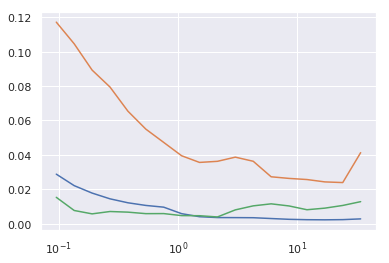

In [35]:
plt.plot(emu.scale_bin_centers, train_err)
plt.plot(emu.scale_bin_centers, acc)
plt.plot(emu.scale_bin_centers, xi_errs)
plt.xscale('log')

In [79]:
resmat_flat = resmat.reshape((-1, 18)).T
datamat_flat = datamat.reshape((-1, 18)).T
#resmat_hodrealav = np.mean(resmat_realav, axis = 1)

In [133]:
r_idx = 10
t_bin = t[r_idx]
acc_bin = np.abs(resmat_flat[r_idx])/datamat_flat[r_idx]

In [135]:
percentiles = np.percentile(acc_bin, range(101))
norm_acc_bin = np.digitize(acc_bin, percentiles)
#norm_acc_bin = 100*((acc_bin - acc_bin.min())/acc_bin.max()).astype(int)

In [136]:
palette = sns.diverging_palette(220, 20, n=len(percentiles)-1, as_cmap=True)
#sns.set_palette(palette)

In [137]:
pnames = emu.get_param_names()

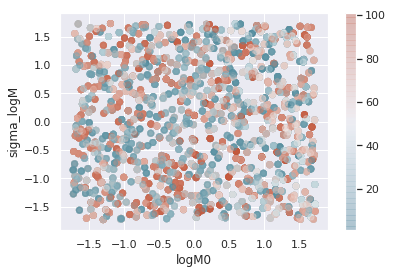

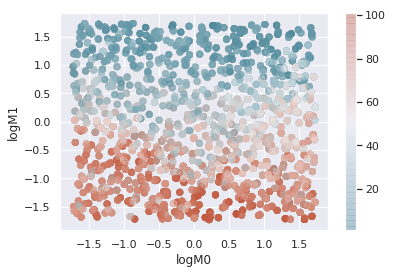

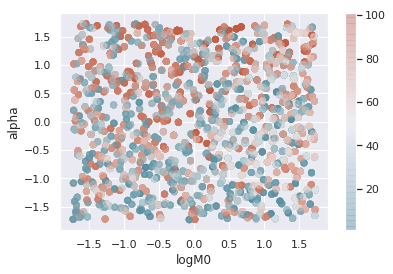

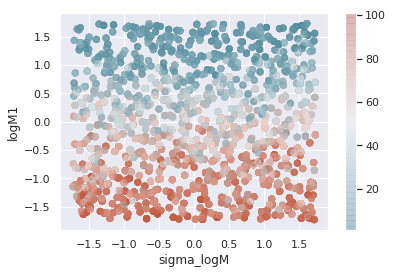

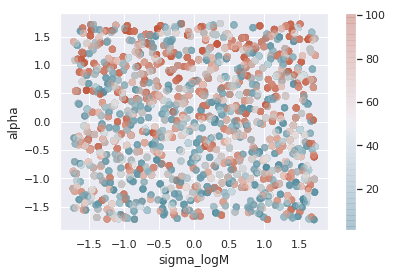

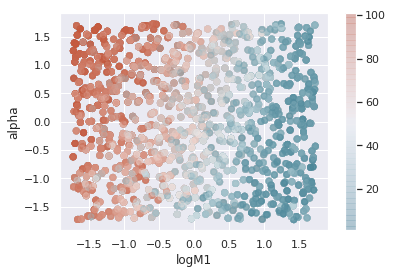

In [138]:
for axes1 in xrange(7,11):
    for axes2 in xrange(axes1+1, 11):
        cbar = plt.scatter(t_bin[:,axes1 ], t_bin[:,axes2], c = norm_acc_bin,cmap = palette, alpha = 0.2)
        plt.colorbar(cbar)
        plt.xlabel(pnames[axes1])
        plt.ylabel(pnames[axes2])
        #plt.gray()
        plt.show()

In [131]:
test_err_bin = test_err[:, r_idx, r_idx]

(array([   52.,   899.,  4645.,  7357.,  8764.,  7489.,  4014.,  1466.,
          283.,    31.]),
 array([-6.75847478, -6.30145219, -5.84442961, -5.38740702, -4.93038444,
        -4.47336185, -4.01633926, -3.55931668, -3.10229409, -2.64527151,
        -2.18824892]),
 <a list of 10 Patch objects>)

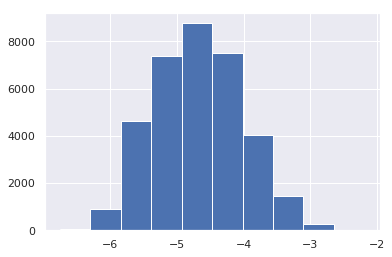

In [132]:
plt.hist(np.log10(test_err_bin) )

# Why are these different?

(array([   164.,   2085.,   8315.,  10257.,   8919.,   5685.,   2963.,
          1287.,    289.,     36.]),
 array([-1.41924799, -1.30072147, -1.18219495, -1.06366842, -0.9451419 ,
        -0.82661538, -0.70808885, -0.58956233, -0.47103581, -0.35250928,
        -0.23398276]),
 <a list of 10 Patch objects>)

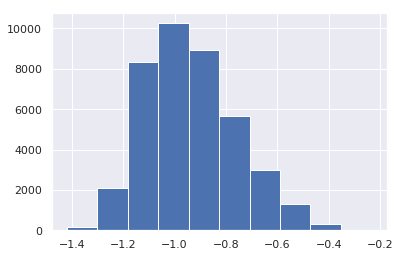

In [120]:
plt.hist(np.log10(np.sqrt(emu.yerr[r_idx])) )

In [110]:
percentiles = np.percentile(np.log10(test_err_bin), [0, 10,20,30,40,50,60,70,80,90,100])
norm_err_bin = np.digitize(np.log10(test_err_bin), percentiles)

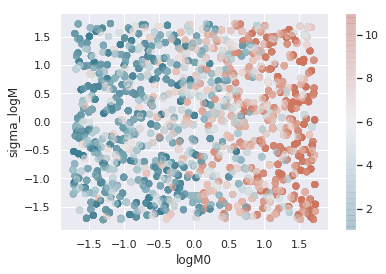

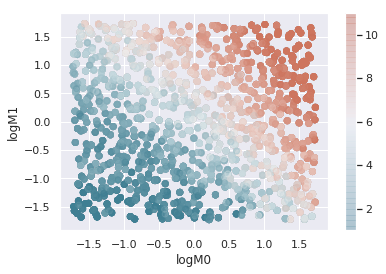

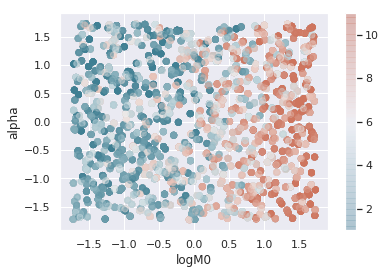

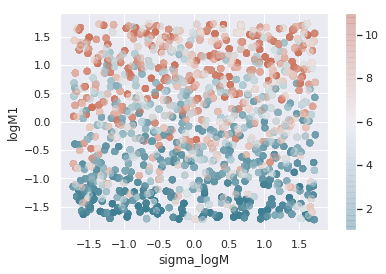

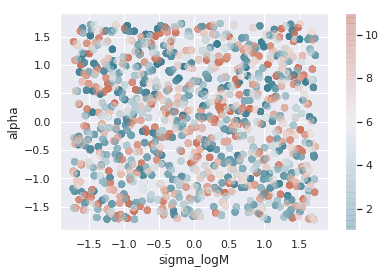

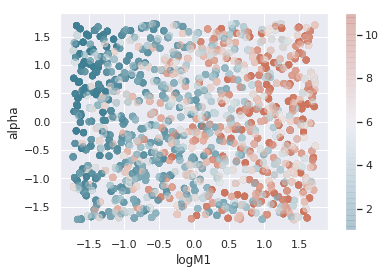

In [121]:
#relevant stat is uncertainty in training error, not test error
for axes1 in xrange(7,11):
    for axes2 in xrange(axes1+1, 11):
        cbar = plt.scatter(t_bin[:,axes1 ], t_bin[:,axes2], c = norm_err_bin,cmap = palette, alpha = 0.2)
        plt.colorbar(cbar)
        plt.xlabel(pnames[axes1])
        plt.ylabel(pnames[axes2])
        #plt.gray()
        plt.show()

In [90]:
test_err_diag= np.array([test_err[:, r_idx, r_idx] for r_idx in xrange(emu.n_bins)] )

In [91]:
test_err_diag.mean(axis = 1)

array([  6.66416262e-04,   3.90266113e-04,   2.40298112e-04,
         1.59608324e-04,   1.11817891e-04,   8.52685284e-05,
         6.85463332e-05,   3.27251532e-05,   1.61159551e-05,
         1.23840494e-05,   1.22300077e-05,   1.20386761e-05,
         8.81174492e-06,   6.19478076e-06,   5.05835371e-06,
         4.66060676e-06,   5.20829565e-06,   7.42500106e-06])

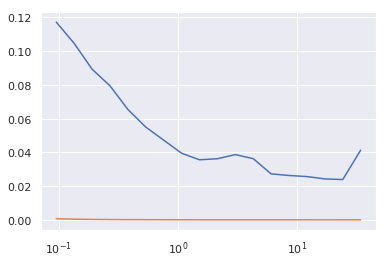

In [112]:
plt.plot(emu.scale_bin_centers, np.mean(np.abs(resmat_flat)/(10**datamat_flat), axis = 1) )
plt.plot(emu.scale_bin_centers, np.mean(np.abs(test_err_diag), axis = 1) )

plt.xscale('log')

In [93]:
resmat_log_flat = resmat_log.reshape((-1, 18)).T

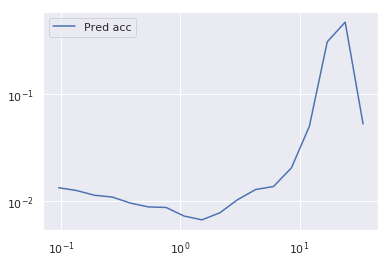

In [113]:
plt.plot(emu.scale_bin_centers, np.mean(np.abs(resmat_log_flat)/np.abs(datamat_flat), axis = 1), label = 'Pred acc' )
#plt.plot(emu.scale_bin_centers, np.mean(np.array([ye/np.abs(y+1e-9) for ye, y in zip(emu.yerr, emu.y)]), axis = 1), label = 'Training Err' )
plt.yscale('log')
plt.legend(loc ='best')
plt.xscale('log')

In [ ]:
for res, dat in zip(resmat_flat, 10**datamat_flat):
    plt.hist(res/dat, bins = 30)#, bins = np.linspace(-1, 1, 30))
    plt.yscale('log')
    plt.show()
